# Model Testing

### Imports

In [276]:
import sys
import ast
import git
import numpy as np
import random
from tqdm.auto import tqdm, trange
import os
from datetime import datetime
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed, wait, ALL_COMPLETED
import networkx as nx
import tree_sitter
from tree_sitter import Language
import json
import requests

In [277]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KMP_BLOCKTIME'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [278]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Attention, Concatenate, Layer,
    Embedding, Dot, Softmax, TimeDistributed, Multiply,
    Lambda, LayerNormalization, MultiHeadAttention,
    Add, Masking, GlobalMaxPooling1D, GlobalMaxPooling2D, Reshape, MaxPooling1D, MaxPooling2D,
    Dropout, Conv1D, Conv2D, Bidirectional, GRU, ConvLSTM2D, Flatten, Permute
)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.cluster import KMeans

from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, CosineSimilarity
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

### Setup of metadata

In [279]:
# ALL_NODE_TYPES = []
# ALL_NODE_INDEXES = []
# i = 0
# for name in dir(ast):
#     if not name.startswith('_'):
#         attr = getattr(ast, name)
#         if isinstance(attr, type) and issubclass(attr, ast.AST):
#             ALL_NODE_TYPES.append(name)
#             ALL_NODE_INDEXES.append(i)
#             i += 1

# MAX_NODE_LOOKUP_NUM = len(ALL_NODE_TYPES)

In [280]:
JS_LANGUAGE = Language('ast-bindings/build/ast.so', 'javascript')
PY_LANGUAGE = Language('ast-bindings/build/ast.so', 'python')
JAVA_LANGUAGE = Language('ast-bindings/build/ast.so', 'java')
C_LANGUAGE = Language('ast-bindings/build/ast.so', 'c')
CPP_LANGUAGE = Language('ast-bindings/build/ast.so', 'cpp')

In [281]:
def download_json_data(lang):
    url = f"https://raw.githubusercontent.com/tree-sitter/tree-sitter-{lang}/master/src/node-types.json"
    data = json.loads(requests.get(url).text)
    types = [node_type["type"] for node_type in data]
    for node_type in data:
        if "subtypes" in node_type:
            subtypes = [subtype["type"] for subtype in node_type["subtypes"]]
            types.extend(subtypes)
    types = list(set(types))
    return types

PYTHON_NODE_TYPES = download_json_data("python")
JAVA_NODE_TYPES = download_json_data("java")
JAVASCRIPT_NODE_TYPES = download_json_data("javascript")
C_NODE_TYPES = download_json_data("c")
CPP_NODE_TYPES = download_json_data("cpp")
ALL_NODE_TYPES = JAVA_NODE_TYPES#list(set(python_data + java_data + javascript_data + c_data + cpp_data))

In [282]:
MAX_NODE_LOOKUP_NUM = len(ALL_NODE_TYPES)
ALL_NODE_INDEXES = range(MAX_NODE_LOOKUP_NUM)

### Helper Functions

In [283]:
def get_random_commit_shas(directory, n):
    # Open the Git repository
    repo = git.Repo(directory)

    # Get the SHA of the latest commit on the main branch
    latest_commit_sha = repo.head.commit.hexsha

    main_branch = repo.heads[0].name
    
    # Get the SHA of the first commit on the main branch
    first_commit_sha = repo.git.rev_list('--max-parents=0', main_branch).splitlines()[0]

    # Create a list of all the commit SHAs on the main branch
    all_commit_shas = [commit.hexsha for commit in repo.iter_commits(main_branch)]

    # Exclude the most recent and first ever commits from the list of possible random commit SHAs
    possible_commit_shas = [sha for sha in all_commit_shas if sha != latest_commit_sha and sha != first_commit_sha]

    # Create an array to store the commit shas
    commit_shas = []

    # Loop n times to generate n random commit shas
    for i in range(n):
        # Generate a random index within the range of possible commit SHAs
        random_index = random.randint(0, len(possible_commit_shas) - 1)

        # Get the commit SHA at the random index
        commit_sha = possible_commit_shas[random_index]

        # Append the commit SHA to the array
        commit_shas.append(commit_sha)

        # Remove the chosen commit SHA from the list of possible commit SHAs to avoid duplicates
        possible_commit_shas.remove(commit_sha)

    # Return the array of commit shas
    return commit_shas


In [284]:
class Commit:
    def __init__(self, sha, repo_path):
        self.sha = sha
        self.repo_path = repo_path
        self.parent = None
        self.author = None
        self.datetime = None
        self.message = None
        self._populate_commit_info()

    def _populate_commit_info(self):
        repo = git.Repo(self.repo_path)
        commit = repo.commit(self.sha)
        self.parent = commit.parents[0].hexsha if commit.parents else None
        self.author = commit.author.name if commit.author else None
        self.datetime = datetime.fromtimestamp(commit.committed_date)
        self.message = commit.message if commit.message else None
        

    def get_testing_y_label(self):
        return 1 if ("fix" in self.message) else 0
        
    def get_files_changed(self):
        try:
            repo = git.Repo(self.repo_path)
            commit = repo.commit(self.sha)
            return [diff.a_path for diff in commit.diff(commit.parents[0]) if diff.a_path.endswith((".java"))][:32]#(('.c', '.cpp', '.java', '.js', '.py'))]
        except:
            return []

    def get_source_at_commit(self, file_name):
        try:
            repo = git.Repo(self.repo_path)
            commit = repo.commit(self.sha)
            return commit.tree[file_name].data_stream.read().decode('utf-8')
        except:
            return ''

    def get_source_at_parent(self, file_name):
        try:
            repo = git.Repo(self.repo_path)
            commit = repo.commit(self.sha)
            return commit.parents[0].tree[file_name].data_stream.read().decode('utf-8')
        except:
            return ''

    def source_to_ast(self, source, file_name):
        try:
            parser = tree_sitter.Parser()
            if file_name.endswith('.c'):
                parser.set_language(C_LANGUAGE)
            elif file_name.endswith('.cpp'):
                parser.set_language(CPP_LANGUAGE)
            elif file_name.endswith('.java'):
                parser.set_language(JAVA_LANGUAGE)
            elif file_name.endswith('.js'):
                parser.set_language(JS_LANGUAGE)
            elif file_name.endswith('.py'):
                parser.set_language(PY_LANGUAGE)
            else:
                print("UNKNOWN LANGUAGE")
                return None
            return parser.parse(bytes(source, 'utf8'))
        except:
            return None
        
    def get_root_paths(self, tree, triplet=False):
        try:
            paths = set()

            # Recursive function to explore the tree
            def explore(node, path, terminalA=None):
                # Add current node to path
                if terminalA is None:
                    terminalA = node
                path.append(node.type)

                # If the node has no children, it's a leaf node and the path is complete
                if not node.child_count:
                    if triplet:
                        paths.add((terminalA.text, tuple(path), node.text))
                    else:
                        paths.add(tuple(path))
                else:
                    # Explore each child node recursively
                    for child in node.children:
                        explore(child, path, terminalA)

                # Remove current node from path before returning
                path.pop()

            # Start exploring from the root node
            root_node = tree.root_node
            explore(root_node, [])
            
            return paths
        except:
            return set([])

    def get_paths(self, ast, padded_length=256, max_depth=None, triplet=False):
        graph = nx.Graph()
        node_id = 0
        leaf_nodes = []

        def add_node(node):
            nonlocal node_id
            node_name = node.type
            node_id += 1
            graph.add_node(node_id, name=node_name, node=node, text=node.text)
            if not node.children:
                leaf_nodes.append(node_id)
            return node_id

        def add_edge(parent_id, child_id):
            graph.add_edge(parent_id, child_id)

        def traverse(node, parent_id=None):
            current_id = add_node(node)
            if parent_id is not None:
                add_edge(parent_id, current_id)
            for child in node.children:
                traverse(child, current_id)

        traverse(ast.root_node)

        leaf_nodes_sample = random.sample(leaf_nodes, min(padded_length, len(leaf_nodes)))
        leaf_node_pairs = [(leaf_nodes_sample[i], leaf_nodes_sample[j]) for i in range(len(leaf_nodes_sample)) for j in range(i+1, len(leaf_nodes_sample))]
        leaf_node_pairs = random.sample(leaf_node_pairs, min(padded_length,len(leaf_node_pairs)))
        
        all_paths = []
        for pair in leaf_node_pairs:
            path = list(nx.all_simple_paths(graph, source=pair[0], target=pair[1]))[0]
            node_types = [graph.nodes[nodeID]['name'] for nodeID in path]
            if(triplet):
                all_paths.append((graph.nodes[pair[0]]['text'], tuple(node_types), graph.nodes[pair[1]]['text']))
            else:
                all_paths.append(tuple(node_types))
                
        return set(all_paths)


    def ast_to_bag_of_contexts(self, ast_trees, only_roots=False, triplet=False, set_path_length=32, padded_length=256):
        paths = set()
        for tree in ast_trees:
            if(only_roots):
                paths |= self.get_root_paths(tree, triplet=triplet)
            else:
                paths |= self.get_paths(tree, triplet=triplet, max_depth=set_path_length, padded_length=padded_length)
        return paths

    def map_bag_of_contexts_to_id(self, bag_of_contexts, all_node_types):
        mapped_paths = []
        for path in bag_of_contexts:
            mapped_path = []
            for node in path:
                index = all_node_types.index(node)
                mapped_path.append(index + 1)
            mapped_paths.append(mapped_path)
        return mapped_paths

    def one_hot_encode(self, bag_of_contexts, max_node_lookup_num):
        one_hot_paths = []

        # Iterate over each row in the array
        for row in bag_of_contexts:
            # Create an empty list to hold the one-hot encodings for this row
            row_one_hot = []

            # Iterate over each element in the row
            for num in row:
                # Create an empty list to hold the one-hot encoding for this number
                num_one_hot = [0] * (max_node_lookup_num + 1)

                # Set the corresponding element to 1
                num_one_hot[int(num)] = 1

                # Add the one-hot encoding for this number to the row's list
                row_one_hot.append(num_one_hot)

            # Add the row's list of one-hot encodings to the main list
            one_hot_paths.append(row_one_hot)

        return one_hot_paths

    def pad_each_context(self, bag_of_contexts, set_path_length, max_node_lookup_num, one_hot=True, ignore_deep_paths=True):
        padded_one_hot_paths = []
        for path in bag_of_contexts:
            if ignore_deep_paths and len(path) > set_path_length:
                continue
            if one_hot:
                padded_path = [[0] * (max_node_lookup_num + 1)] * max(set_path_length - len(path), 0) + path[-set_path_length:]
            else:
                padded_path = [0] * max(set_path_length - len(path), 0) + path[-set_path_length:]
            padded_one_hot_paths.append(padded_path)
        return padded_one_hot_paths

    def to_raw_consumable_data(
        self,
        onehot=False,
        padded_length=256,
        all_node_types=ALL_NODE_TYPES,
        max_node_lookup_num=MAX_NODE_LOOKUP_NUM,
        set_path_length=32,
        only_root_paths=False,
        ignore_deep_paths=True,
        triplet=False
    ):
        files_changed = self.get_files_changed()
        sources_at_commit = [self.get_source_at_commit(filename) for filename in files_changed]
        sources_at_parent = [self.get_source_at_parent(filename) for filename in files_changed]        

        asts_commit = [self.source_to_ast(source, files_changed[i]) for i, source in enumerate(sources_at_commit)]
        asts_parent = [self.source_to_ast(source, files_changed[i]) for i, source in enumerate(sources_at_parent)]
        
        contexts_commit = self.ast_to_bag_of_contexts(asts_commit, only_roots=only_root_paths, triplet=triplet, set_path_length=set_path_length, padded_length=padded_length)
        contexts_parent = self.ast_to_bag_of_contexts(asts_parent, only_roots=only_root_paths, triplet=triplet, set_path_length=set_path_length, padded_length=padded_length)

        contexts = list(contexts_commit.symmetric_difference(contexts_parent))

        
        contexts = self.map_bag_of_contexts_to_id(contexts, all_node_types)

        if(onehot):
            contexts = self.one_hot_encode(contexts, max_node_lookup_num)

        contexts = self.pad_each_context(contexts, set_path_length, max_node_lookup_num, one_hot=onehot, ignore_deep_paths=ignore_deep_paths)

        return contexts
    
    def raw_to_padded(self, consumable, padded_length=256, onehot=False, set_path_length=32, max_node_lookup_num=MAX_NODE_LOOKUP_NUM):
        if(len(consumable) == padded_length):
            return consumable
        
        if(len(consumable) > padded_length):
            return random.sample(consumable, padded_length)
        
        if onehot:
            blank_path = [[0] * (max_node_lookup_num + 1)] * set_path_length
        else:
            blank_path = ([0] * set_path_length)
            
        return ([blank_path] * (padded_length - len(consumable)) + consumable)

    
    def to_padded_consumable_data(
        self,
        padded_length=256,
        onehot=False,
        all_node_types=ALL_NODE_TYPES,
        max_node_lookup_num=MAX_NODE_LOOKUP_NUM,
        set_path_length=32,
        only_root_paths=False,
        ignore_deep_paths=True,
        triplet=False
    ):
        consumable = self.to_raw_consumable_data(onehot=onehot, all_node_types=all_node_types, padded_length=padded_length, max_node_lookup_num=max_node_lookup_num, set_path_length=set_path_length, only_root_paths=only_root_paths, ignore_deep_paths=ignore_deep_paths)
        padded = self.raw_to_padded(consumable, padded_length=padded_length, onehot=onehot, set_path_length=set_path_length, max_node_lookup_num=max_node_lookup_num)
        if(onehot):
            padded = np.array(padded)
            padded = padded.reshape(padded.shape[0], padded.shape[1] * padded.shape[2])
            padded = padded.tolist()
        return padded


### Data Configuration and Generation

In [285]:
#Set this to any git repo on your local
REPO_PATH = "/home/brennan/hbase"

#Number of training examples to generate
DATA_SIZE = 512

#Number of contexts to pad/reduce to per sample
EXAMPLE_SIZE = 200

#Maximum depth of context
CONTEXT_SIZE = 12

#Internal fixed length representation size
OUTPUT_SIZE = 512

ONE_HOT = False
if(ONE_HOT):
    INPUT_SHAPE = (EXAMPLE_SIZE, CONTEXT_SIZE * (MAX_NODE_LOOKUP_NUM + 1))
else:
    INPUT_SHAPE = (EXAMPLE_SIZE, CONTEXT_SIZE)
    
ONLY_ROOT_PATHS=False
IGNORE_DEEP_PATHS=True
USE_FULL_TUPLES=False #NOT working yet

In [286]:
# COMMITS = [Commit(sha, REPO_PATH) for sha in tqdm(get_random_commit_shas(REPO_PATH, DATA_SIZE), desc="Mining random commit SHAs")]
#X_train = [c.to_padded_consumable_data(padded_length=EXAMPLE_SIZE, onehot=ONE_HOT, set_path_length=CONTEXT_SIZE, only_root_paths=ONLY_ROOT_PATHS) for c in tqdm(COMMITS, desc="Converting commit diffs to padded consumable data")]

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(lambda sha: Commit(sha, REPO_PATH), sha) for sha in get_random_commit_shas(REPO_PATH, DATA_SIZE)]
    pbar = tqdm(total=len(futures), desc="Mining random commit SHAs")
    done = set()
    while len(done) < len(futures):
        for future in set(futures) - done:
            if future.done():
                pbar.update(1)
                done.add(future)
        pbar.refresh()
    COMMITS = [future.result() for future in done]

with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(commit.to_padded_consumable_data, triplet=USE_FULL_TUPLES, padded_length=EXAMPLE_SIZE, onehot=ONE_HOT, set_path_length=CONTEXT_SIZE, only_root_paths=ONLY_ROOT_PATHS, ignore_deep_paths=IGNORE_DEEP_PATHS) for commit in COMMITS]
    pbar = tqdm(total=len(futures), desc="Converting commit diffs to padded consumable data")
    done = set()
    while len(done) < len(futures):
        for future in set(futures) - done:
            if future.done():
                pbar.update(1)
                done.add(future)
        pbar.refresh()
    X_train = [future.result() for future in done]


y_train = [c.get_testing_y_label() for c in tqdm(COMMITS, desc="Getting testing labels")]

Mining random commit SHAs:   0%|          | 0/512 [00:00<?, ?it/s]

Converting commit diffs to padded consumable data:   0%|          | 0/512 [00:00<?, ?it/s]

Getting testing labels:   0%|          | 0/512 [00:00<?, ?it/s]

In [287]:
# n_minority_class = np.sum(y_train == 1)
# n_majority_class = np.sum(y_train == 0)

# # Calculate the number of samples to randomly remove from the majority class
# n_samples_to_remove = n_majority_class - n_minority_class

# # Get the indices of the majority class samples
# majority_class_indices = np.where(y_train == 0)[0]

# # Randomly select a subset of majority class samples to remove
# majority_class_indices_to_remove = np.random.choice(majority_class_indices, size=n_samples_to_remove, replace=False)

# # Remove the selected majority class samples from X_train and y_train
# X_train_balanced = np.delete(X_train, majority_class_indices_to_remove, axis=0)
# y_train_balanced = np.delete(y_train, majority_class_indices_to_remove)

# X_train, X_test, y_train, y_test = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [289]:
print(np.sum(y_train)/len(y_train), len(y_train))

0.03178484107579462 409


### Representation Learning

In [290]:
class CommitDiffModel:
    def __init__(
        self,
        input_shape,
        example_size,
        context_size,
        fixed_vector_size,
    ):
        self.input_shape = input_shape
        self.example_size = example_size
        self.context_size = context_size
        self.fixed_vector_size = fixed_vector_size
        self.num_heads = 4
        self.key_dim = 512
        self.units = 128
        self.rate = 0.1
        self.activation_fn1 = "relu"
        self.activation_fn2 = "relu"
        self.activation_fn3 = "relu"
        self.optimizer = "adam"
        self.loss_fn = "mse"
        self.temperature = 0.1
        self.encoder = None
        self.siam_model = None
        self.binary_classification_model = None

    def initialize(self):
        self.encoder = self.build_encoder()
        self.siam_model = self.build_siam_model()
        self.binary_classification_model = self.build_binary_classification_model()
        
    def encoder_attention_feed_forward(self, inputs):
        
        inputs = Reshape((self.example_size, -1))(inputs)
        
        # Self-attention layer to obtain attention weights
        self_attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)(inputs, inputs)
        
        normalized = LayerNormalization()(self_attention)
        
        # Feedforward layers
        feedforward = TimeDistributed(Dense(units=self.units, activation=self.activation_fn1))(normalized)

        # Global max pooling layer to produce a fixed-length output vector representation
        pooled = MaxPooling1D(pool_size=self.context_size)(feedforward)

        return pooled
    
    def encoder_attention_weighted(self, inputs):
        
        # Add a self-attention layer to compute attention weights for each context
        self_attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)(inputs, inputs)

        # Add a layer normalization layer to normalize the self-attention output
        normalized = LayerNormalization()(self_attention)

        # Add a feedforward layer to compute context-level encodings
        encoded = Dense(units=self.units, activation='relu')(normalized)

        # Compute attention weights based on the contents of each context
        attention_weights = Dense(units=1, activation='softmax')(encoded)

        # Compute a weighted sum of the contexts using attention weights
        weighted_sum = tf.keras.layers.Dot(axes=1)([attention_weights, encoded])
        
        return weighted_sum
    
    
    #NOTE: Conceptually good, but doesn't actually compile :(
    def encoder_softmax_pooled(self, inputs):
        
        # Self-attention layer to obtain attention weights
        self_attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)(inputs, inputs)

        # Compute attention weights and apply them to the inputs
        attention_weights = Softmax()(self_attention)
        weighted_inputs = Multiply()([attention_weights, inputs])

        # Sum pooling to aggregate the weighted bag
        pooled_inputs = Lambda(lambda x: K.sum(x, axis=1))(weighted_inputs)

        normalized = LayerNormalization()(pooled_inputs)
        
        # Feedforward layers
        feedforward = TimeDistributed(Dense(units=self.units, activation=self.activation_fn1))(normalized)

        # Global max pooling layer to produce a fixed-length output vector representation
        pooled = MaxPooling1D(pool_size=self.context_size)(feedforward)

        return pooled
    
    #Best so far. Haven't played with hyperparams
    def encoder_recurrent_convolutional(self, inputs):
       
        # Add a 1D convolutional layer to extract features from each context
        conv = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)

        # Add a max pooling layer to summarize the extracted features
        max_pooling = MaxPooling1D(pool_size=self.context_size)(conv)

        # Add a recurrent layer to capture temporal dependencies within each context
        lstm = LSTM(units=64)(max_pooling)

        return lstm
    
    def encoder_hierarchical(self, inputs):
        
        # Encode each individual context using a bidirectional LSTM layer
        encoded_contexts = Bidirectional(LSTM(units=self.units, return_sequences=True))(inputs)

        # Compute a weighted sum of the context-level encodings, using attention weights based on the contents of each context
        attention_weights = TimeDistributed(Dense(units=1, activation='softmax'))(encoded_contexts)
        weighted_sum = tf.keras.layers.Dot(axes=1)([attention_weights, encoded_contexts])

        return weighted_sum
        
    def build_encoder(self):
        
        inputs = Input(shape=self.input_shape)

        masked_inputs = Masking()(inputs)
        
        ##########################################################
        
        # encoded = self.encoder_attention_feed_forward(masked_inputs)
        # encoded = self.encoder_softmax_pooled(masked_inputs) #Broken
        encoded = self.encoder_recurrent_convolutional(masked_inputs) #Best so far with small inputs
        # encoded = self.encoder_attention_weighted(masked_inputs)
        # encoded = self.encoder_hierarchical(masked_inputs)
        
        ##########################################################

        # Dropout layer to prevent overfitting
        dropout = Dropout(rate=self.rate)(encoded)

        # Fixed length vector representation
        outputs = Dense(units=self.fixed_vector_size)(dropout)

        # Define encoder model
        encoder = tf.keras.Model(inputs=inputs, outputs=outputs)
        return encoder
    
    def build_siam_model(self):
        
        # Create SimSiam model
        x1 = Input(shape=self.input_shape)
        x2 = Input(shape=self.input_shape)
        
        x1 = tf.random.shuffle(x1)
        x2 = tf.random.shuffle(x2)
        
        # Encode the input twice using the same encoder
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        # Predict a transformation of the first encoding
        p1 = Dense(units=self.fixed_vector_size, activation=self.activation_fn2)(z1)
        p2 = Dense(units=self.fixed_vector_size, activation=self.activation_fn2)(z1)
        
        #Loss function
        def D(p, z):
            z = tf.stop_gradient(z)
            p = tf.math.l2_normalize(p, axis=1)
            z = tf.math.l2_normalize(z, axis=1)
            return -tf.reduce_mean(tf.reduce_sum(p * z, axis=1))
        
        loss = D(p1, z2) / 2 + D(p2, z1) / 2
        
        # Define the model
        model = tf.keras.Model(inputs=[x1,x2], outputs=loss)
        
        # Compile the model
        model.compile(optimizer=self.optimizer, loss=lambda _, loss: loss)
        
        return model

    def build_binary_classification_model(self):
        
        # Create binary classification model
        inputs = Input(shape=self.input_shape)
        
        # Encode inputs using the same encoder model
        encoded = self.encoder(inputs)
        for layer in self.encoder.layers:
            layer.trainable = False
        
        # Binary classification output
        binary_classification = Dense(units=64, activation=self.activation_fn3)(encoded)
        binary_classification = Dense(units=32, activation=self.activation_fn3)(binary_classification)
        binary_classification = Dense(units=1, activation=self.activation_fn3)(binary_classification)
        
        # Define model
        model = tf.keras.Model(inputs=inputs, outputs=binary_classification)
        
        # Compile model
        model.compile(optimizer=self.optimizer, loss="mse")
        
        return model

    def fit_siam(self, X_train, epochs, batch_size, verbose=0):        
        self.siam_model.fit([X_train, X_train], [X_train, X_train], epochs=epochs, batch_size=batch_size, verbose=verbose)
        
    def fit_binary_classification(self, X_train, y_train, epochs, batch_size, verbose=0):
        self.binary_classification_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    def evaluate_binary_classification(self, X_test, y_test, verbose=0):
        return self.binary_classification_model.evaluate(X_test, y_test, verbose=verbose)


In [291]:
model = CommitDiffModel(
    input_shape=INPUT_SHAPE,
    example_size=EXAMPLE_SIZE,
    context_size=CONTEXT_SIZE,
    fixed_vector_size=OUTPUT_SIZE
)
model.initialize()

In [292]:
model.fit_siam(np.array(X_train), epochs=8, batch_size=8, verbose=1)

Epoch 1/8
52/52 [==============================] - 4s 13ms/step - loss: -0.5909
Epoch 2/8
52/52 [==============================] - 1s 13ms/step - loss: -0.6942
Epoch 3/8
52/52 [==============================] - 1s 13ms/step - loss: -0.7029
Epoch 4/8
52/52 [==============================] - 1s 13ms/step - loss: -0.7105
Epoch 5/8
52/52 [==============================] - 1s 13ms/step - loss: -0.7208
Epoch 6/8
52/52 [==============================] - 1s 13ms/step - loss: -0.7108
Epoch 7/8
52/52 [==============================] - 1s 13ms/step - loss: -0.7003
Epoch 8/8
52/52 [==============================] - 1s 14ms/step - loss: -0.6562


In [293]:
model.fit_binary_classification(np.array(X_train), np.array(y_train), epochs=4, batch_size=32, verbose=1)

Epoch 1/4
13/13 [==============================] - 2s 7ms/step - loss: 0.0318
Epoch 2/4
13/13 [==============================] - 0s 6ms/step - loss: 0.0318
Epoch 3/4
13/13 [==============================] - 0s 6ms/step - loss: 0.0318
Epoch 4/4
13/13 [==============================] - 0s 6ms/step - loss: 0.0318


In [294]:
model.evaluate_binary_classification(np.array(X_test), np.array(y_test), verbose=0)

0.06796116381883621

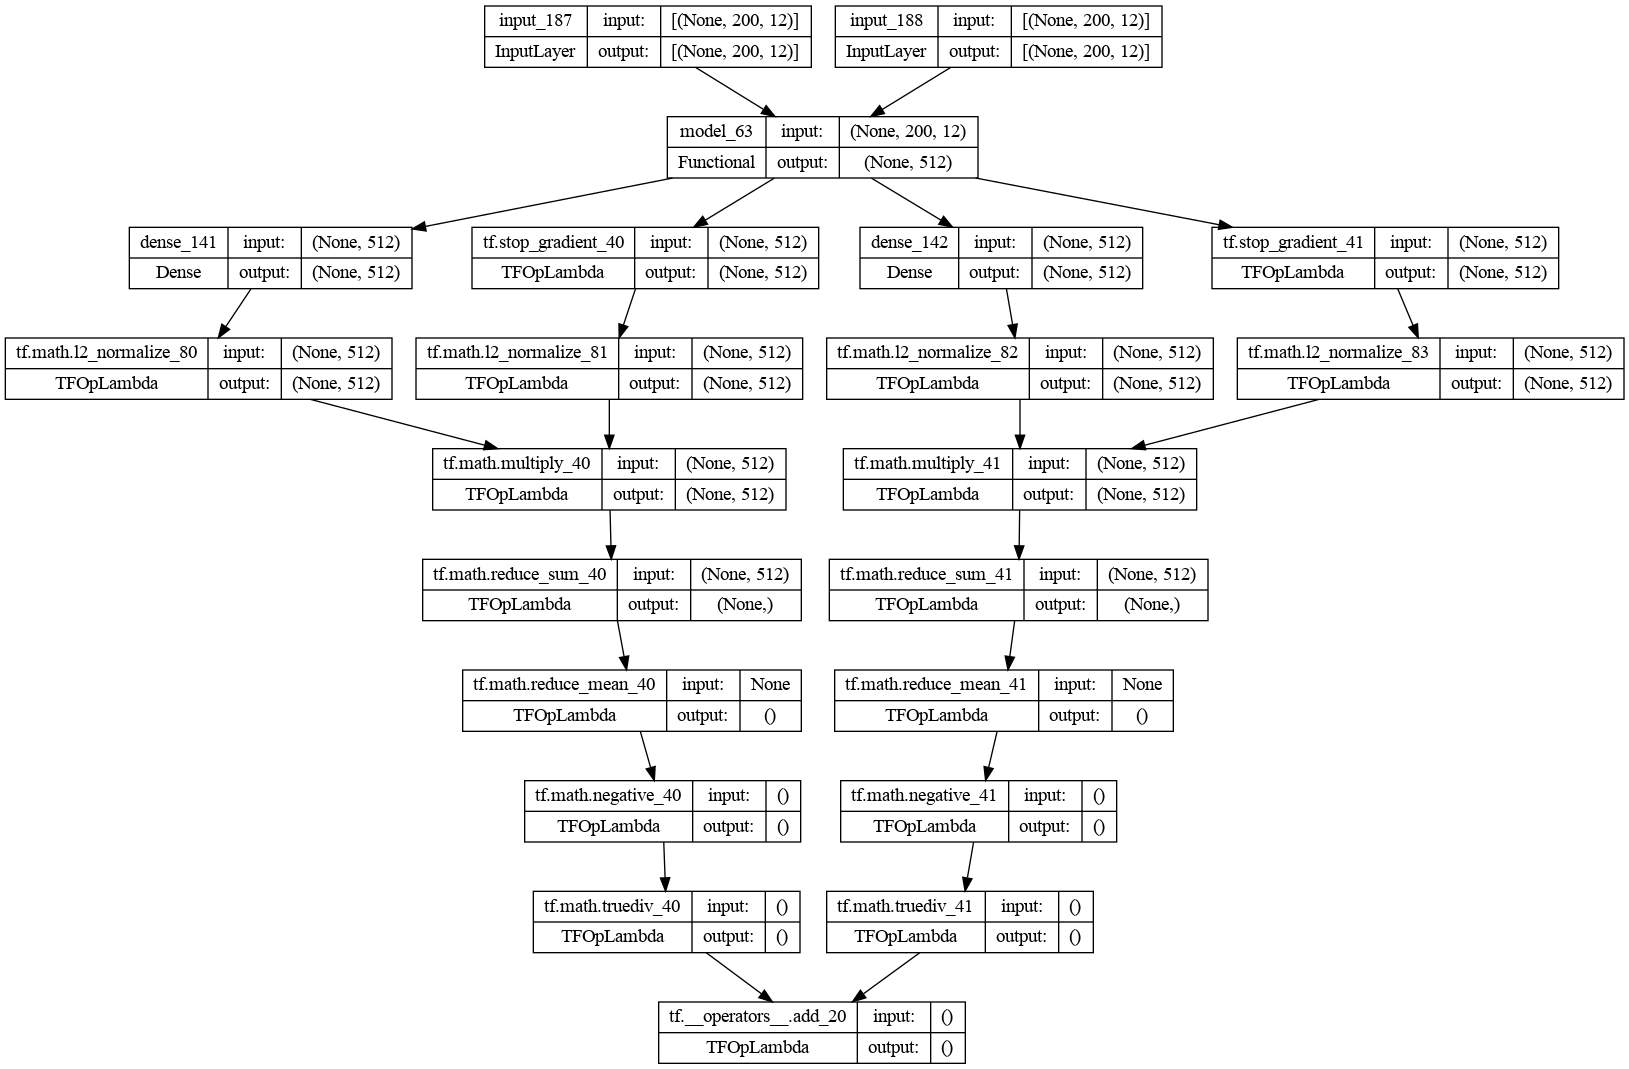

In [295]:
plot_model(model.siam_model, show_shapes=True, show_layer_names=True)

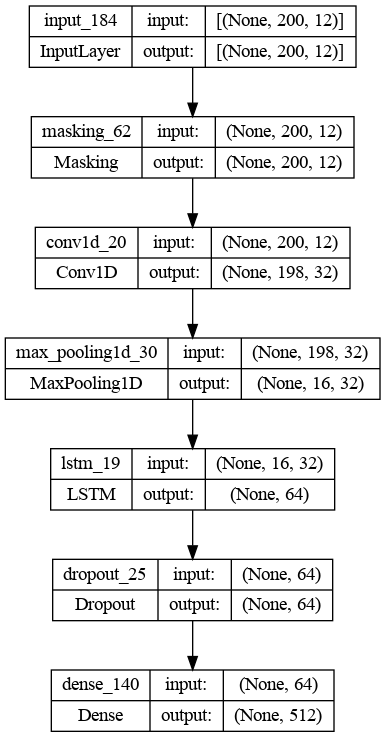

In [296]:
plot_model(model.encoder, show_shapes=True, show_layer_names=True)

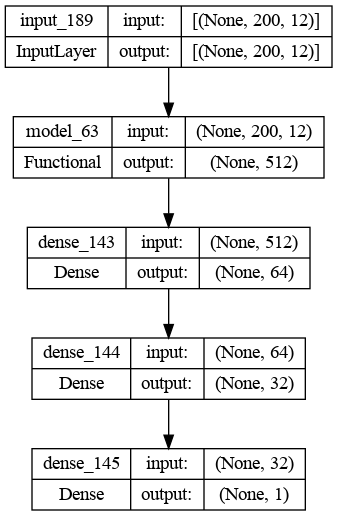

In [297]:
plot_model(model.binary_classification_model, show_shapes=True, show_layer_names=True)